In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import multitask.dataset as dataset
from multitask.models.task_switching import get_task_model
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figureS11_weights_contexts_layers.svg')
path_model_task_switching = os.path.join('..', '..', 'results', 'task_switching')

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 10 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']
num_tasks = len(tasks_names)

In [5]:
num_layers = len(num_hidden)
list_results = []

for max_contexts in range(1, num_layers+1):

    idxs_contexts = list(range(max_contexts))
    num_hidden_contexts = len(idxs_contexts) * [num_hidden[0]]
    print(idxs_contexts, num_hidden_contexts)

    parameters = {
        'num_runs': num_runs,
        'initial_seed': initial_seed,
        'max_seed': max_seed,
        'num_epochs': num_epochs,
        'num_hidden': num_hidden_contexts,
        'batch_size': batch_size,
        'num_train': num_train,
        'num_test': num_test,
        'tasks': tasks_names,
        'idxs_contexts': idxs_contexts
    }

    data_folder = check_runs(path_model_task_switching, parameters)

    pickle_data = os.path.join(data_folder, 'data.pickle')
    with open(pickle_data, 'rb') as handle:
        results_task_switching = pickle.load(handle)
    list_results.append(results_task_switching)


[0] [100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-27_22_43_28)
[0, 1] [100, 100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-27_23_19_27)
[0, 1, 2] [100, 100, 100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_00_11)
[0, 1, 2, 3] [100, 100, 100, 100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_45_25)
[0, 1, 2, 3, 4] [100, 100, 100, 100, 100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_00_18_47)
[0, 1, 2, 3, 4, 5] [100, 100, 100, 100, 100, 100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_01_39_04)
[0, 1, 2, 3, 4, 5, 6] [100, 100, 100, 100, 100, 100, 100]
Found simulation in ../../results/task_switching with the same parameters (2022-09-28_02_46_35)
[0, 1, 2, 3, 4, 5, 6, 7] [100, 100, 100, 100, 100, 100, 100, 100]
Found simulation in ../.

In [6]:
if num_tasks > 2:
    raise NotImplementedError

In [7]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

task_switching_tasks = {}
num_tasks = len(tasks_names)

for i_context, task_name in enumerate(tasks_names):
    task_switching_tasks[task_name] = {}
    task_switching_tasks[task_name]['data'] = tasks_datasets[task_name]
    task_switching_tasks[task_name]['activations'] = num_tasks * [0]
    task_switching_tasks[task_name]['activations'][i_context] = 1

for key, value in task_switching_tasks.items():
    print(f'{key}: {value["activations"]}')

parity: [1, 0]
value: [0, 1]


In [8]:
device = get_device()

norm_weights_parity = np.zeros((num_runs, num_layers, num_layers))
norm_weights_value = np.zeros((num_runs, num_layers, num_layers))
correlations = np.zeros((num_runs, num_layers, num_layers))

for i_results, results in enumerate(list_results):
    seeds = list(results.keys())
    idxs_contexts = list(range(i_results+1))
    num_hidden_contexts = len(idxs_contexts) * [num_hidden[0]]
    print(idxs_contexts, num_hidden_contexts)
    for j_seed, seed in enumerate(seeds):
        state_dict = results[seed]['model']
        model = get_task_model(task_switching_tasks,
                               num_hidden_contexts,
                               idxs_contexts,
                               device)
        model.load_state_dict(state_dict)
        for k_context in idxs_contexts:
            weights = model.layers[k_context].weight.detach().cpu().numpy()
            norm_parity, norm_value = np.linalg.norm(weights[:, -2:], axis=0)
            norm_weights_parity[j_seed, i_results, k_context] = norm_parity
            norm_weights_value[j_seed, i_results, k_context] = norm_value

            weights_parity = np.array(weights[:, -2])
            weights_value = np.array(weights[:, -1])
            correlations[j_seed, i_results, k_context] = np.corrcoef(weights_parity, weights_value)[0, 1]
            

Running on CPU.
[0] [100]
[0, 1] [100, 100]
[0, 1, 2] [100, 100, 100]
[0, 1, 2, 3] [100, 100, 100, 100]
[0, 1, 2, 3, 4] [100, 100, 100, 100, 100]
[0, 1, 2, 3, 4, 5] [100, 100, 100, 100, 100, 100]
[0, 1, 2, 3, 4, 5, 6] [100, 100, 100, 100, 100, 100, 100]
[0, 1, 2, 3, 4, 5, 6, 7] [100, 100, 100, 100, 100, 100, 100, 100]
[0, 1, 2, 3, 4, 5, 6, 7, 8] [100, 100, 100, 100, 100, 100, 100, 100, 100]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


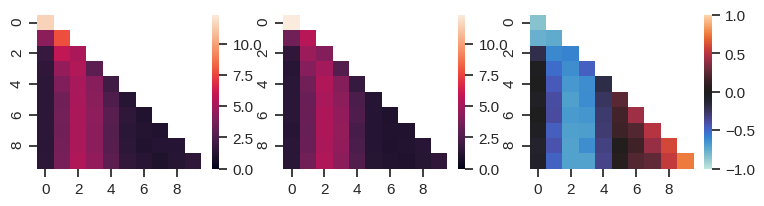

In [9]:
mean_weights_parity = norm_weights_parity.mean(axis=0)
std_weights_parity = norm_weights_parity.std(axis=0)

mean_weights_value = norm_weights_value.mean(axis=0)
std_weights_value = norm_weights_value.std(axis=0)

mean_correlations = correlations.mean(axis=0)
std_correlations = correlations.std(axis=0)

mask = np.triu(1 - mean_correlations.astype(bool))
vmax = np.max([mean_weights_parity.max(), mean_weights_value.max()])

fig, ax = plt.subplots(1, 3, figsize=(9, 2))
sns.heatmap(mean_weights_parity, ax=ax[0], mask=mask, vmin=0, vmax=vmax)
sns.heatmap(mean_weights_value, ax=ax[1], mask=mask, vmin=0, vmax=vmax)
sns.heatmap(mean_correlations, ax=ax[2], cmap='icefire', mask=mask, vmin=-1, vmax=1)

# ax[0].set_xticks(range(num_layers))
# ax[0].set_yticks(range(num_layers))
# ax[0].set_xticklabels(range(1, num_layers+1), fontsize=12)
# ax[0].set_yticklabels(range(1, num_layers+1), fontsize=12)

# ax[1].set_xticks(range(num_layers))
# ax[1].set_yticks(range(num_layers))
# ax[1].set_xticklabels(range(1, num_layers+1), fontsize=12)
# ax[1].set_yticklabels(range(1, num_layers+1), fontsize=12)

# ax[2].set_xticks(range(num_layers))
# ax[2].set_yticks(range(num_layers))
# ax[2].set_xticklabels(range(1, num_layers+1), fontsize=12)
# ax[2].set_yticklabels(range(1, num_layers+1), fontsize=12)

fig.savefig(path_figure)

plt.show()